In this notebook, we focused on performing a thorough exploratory data analysis (EDA) and preprocessing pipeline in preparation for modeling ransomware and benign behavior based on low-level memory and storage access statistics. The goal was to carefully clean and analyze the dataset without rushing into modeling, to ensure that everything was properly understood and prepared first.

We began by loading the dataset (final_dataset_balanced.parquet), which contains about 194,000 samples and 26 columns, including meta-data like family and label (the ground truth). We checked the dataset dimensions, column types, and confirmed that there were no missing values in any columns. We also verified the distribution of labels (benign vs ransomware), which was well balanced, and listed the unique families involved, which are twelve in total, mixing benign applications (such as Firefox and Office) and ransomware families (such as LockBit and REvil).

Next, we performed descriptive statistical analysis using .describe(). This helped us spot immediately that many features were highly skewed and contained extreme outliers or heavy right tails. Some of them, especially counts and variances, contained many zeros and very high maximum values. Based on this, we calculated the skewness for all numerical features, which confirmed that a large number of them were strongly skewed, which could negatively affect modeling if not handled. We considered applying log1p to fix this, but decided to visualize the distributions first.

We then created clean visualizations of all numerical feature distributions using histograms and KDEs. These were done in a compact grid style (3 columns per row) to keep them easy to analyze. This was done first overall, and then grouped by class (benign vs ransomware). These visualizations revealed that many features, like write_entropy, write_throughput, and read_lba_var, showed very clear differences between benign and ransomware samples. Others, however, such as some memory counters and variances, had weak or almost non-existent differences.

We also detected constant and quasi-constant features. We found that four features (mem_read_count_4k, mem_write_count_4k, mem_readwrite_count_4k, and mem_exec_count_4k) were completely constant across the dataset. Instead of removing them right away, we double-checked their variances grouped by family to make sure they were not informative on a family level either. They turned out to be zero for all families, so we safely dropped them.

After that, we analyzed class and family distributions through bar plots. The class distribution was well balanced, which means that no special handling is needed to avoid model bias. Family distribution was also relatively even, although some ransomware families had slightly fewer samples (Ryuk being the smallest). However, nothing indicated an issue requiring balancing actions at this point.

Once we understood the overall distributions, we generated the most insightful plots so far: class-wise histograms for every numerical feature. This showed very clearly how ransomware tends to differ from benign samples. Ransomware families had higher values in entropy and throughput related features, which is consistent with the expected encryption and aggressive IO behaviors. This means models should be able to learn these patterns effectively.

To dive deeper, we repeated this visualization per family (rather than per class). This was very useful to assess whether families have their own behaviors or if they all blend together. The family-wise plots confirmed that while benign families were generally tightly clustered and calm, ransomware families showed more spread and variation. This is actually good news for ML because it means the model can learn different family styles while still discriminating ransomware from benign globally.

Following the distributional analysis, we moved to feature correlation analysis. We computed a correlation matrix and plotted a heatmap. This helped us observe which features are strongly related to each other, which is important to detect redundancy that may hurt or confuse some models. While many correlations were weak to moderate, we spotted a few strong correlations, especially between write_throughput and write_lba_var, which exceeded 0.9. We listed these top correlations in a clean table to document them. We did not remove them immediately, but flagged them as potential candidates for later reduction.

Before closing the notebook, we remembered to address one critical step: scaling. Since our dataset features varied drastically in scale (some were counts, others variances, and some entropy values between 0 and 1), leaving them as-is would hurt most ML algorithms that assume equal weighting of features. We decided that the best scaling option for our case was StandardScaler (z-score scaling), because MinMaxScaler would not handle skewness properly and we do not care about preserving the 0-1 range. StandardScaler rescales features to zero mean and unit variance, making them more comparable and improving model convergence without distorting their relative patterns.

Finally, after applying StandardScaler to all numerical features, we saved the fully prepared dataset into a new parquet file (final_prepared_dataset.parquet), which will be used as input for the next stage of the project: model building.

In summary, this notebook finalized a complete and careful preprocessing workflow:

    We loaded and inspected the data.

    We checked and confirmed class and family distributions.

    We analyzed feature distributions, skewness and detected constant features.

    We visualized differences between benign and ransomware, as well as family-specific patterns.

    We analyzed feature correlations and flagged redundant pairs.

    We scaled the data to prepare it for modeling.

    Finally, we saved the clean dataset for the next notebook.

The dataset is now ready to move into the modeling phase confidently and safely.

In [28]:
import pandas as pd
import numpy as np

df = pd.read_parquet('../Datasets/final_dataset_balanced.parquet')

print(f"Dataset contains {df.shape[0]} rows and {df.shape[1]} columns.")

df.info()

Dataset contains 194466 rows and 26 columns.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 194466 entries, 0 to 194465
Data columns (total 26 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   family                    194466 non-null  object 
 1   window_id                 194466 non-null  int64  
 2   read_throughput           194466 non-null  float64
 3   read_lba_var              194466 non-null  float64
 4   write_throughput          194466 non-null  float64
 5   write_lba_var             194466 non-null  float64
 6   write_entropy             194466 non-null  float64
 7   mem_read_count_4k         194466 non-null  int64  
 8   mem_read_count_2m         194466 non-null  int64  
 9   mem_read_count_mmio       194466 non-null  int64  
 10  mem_read_gpa_var          194466 non-null  float64
 11  mem_write_entropy         194466 non-null  float64
 12  mem_write_count_4k        194466 non-null  int64  
 13 

In [3]:
display(df.head())

print("Label distribution:", df['label'].value_counts().to_dict())
print("Unique families:", df['family'].unique())

missing = df.isnull().sum()
print("\nMissing values per column:")
print(missing[missing > 0] if missing.sum() > 0 else "No missing values.")

family  window_id  read_throughput  read_lba_var  write_throughput  \
0  AESCrypt          0              0.0           0.0               0.0   
1  AESCrypt          1              0.0           0.0               0.0   
2  AESCrypt          2              0.0           0.0               0.0   
3  AESCrypt          5              0.0           0.0               0.0   
4  AESCrypt          6              0.0           0.0               0.0   

   write_lba_var  write_entropy  mem_read_count_4k  mem_read_count_2m  \
0            0.0            0.0                  0                  6   
1            0.0            0.0                  0                  0   
2            0.0            0.0                  0                  0   
3            0.0            0.0                  0                  0   
4            0.0            0.0                  0                  0   

   mem_read_count_mmio  ...  mem_readwrite_entropy  mem_readwrite_count_4k  \
0                  314  ...               0.749489                       0   
1                  214  ...               0.843179                       0   
2                   20  ...               0.643699                       0   
3                    9  ...               0.837807                       0   
4                    1  ...               0.000000                       0   

   mem_readwrite_count_2m  mem_readwrite_count_mmio  mem_readwrite_gpa_var  \
0                       0                        14           3.023757e+19   
1                       0                         1           0.000000e+00   
2                       0                         1           0.000000e+00   
3                       0                         2           9.921287e+16   
4                       0                         0           0.000000e+00   

   mem_exec_count_4k  mem_exec_count_2m  mem_exec_count_mmio  \
0                  0                  0                   89   
1                  0                  0                    6   
2                  0                  0                    5   
3                  0                  0                    6   
4                  0                  0                    1   

   mem_exec_gpa_var  label  
0      4.227084e+19      0  
1      2.081018e+19      0  
2      2.437121e+19      0  
3      3.505556e+19      0  
4      0.000000e+00      0  

[5 rows x 26 columns]

Label distribution: {0: 101443, 1: 93023}
Unique families: ['AESCrypt' 'Conti' 'Darkside' 'Firefox' 'Idle' 'LockBit' 'Office' 'REvil'
 'Ryuk' 'SDelete' 'WannaCry' 'Zip']

Missing values per column:
No missing values.


In [4]:
df.describe().T

count          mean           std  min       25%  \
window_id                 194466.0  9.850865e+02  5.962140e+02  0.0     467.0   
read_throughput           194466.0  9.889719e+06  1.841801e+07  0.0       0.0   
read_lba_var              194466.0  2.374124e+14  4.552286e+14  0.0       0.0   
write_throughput          194466.0  8.495440e+06  2.691218e+07  0.0       0.0   
write_lba_var             194466.0  3.043790e+14  7.517056e+14  0.0       0.0   
write_entropy             194466.0  2.408592e-01  3.332804e-01  0.0       0.0   
mem_read_count_4k         194466.0  0.000000e+00  0.000000e+00  0.0       0.0   
mem_read_count_2m         194466.0  2.569601e-02  4.455524e-01  0.0       0.0   
mem_read_count_mmio       194466.0  2.835591e+00  1.231257e+01  0.0       0.0   
mem_read_gpa_var          194466.0  3.024197e+18  1.651046e+20  0.0  120643.0   
mem_write_entropy         194466.0  5.689100e-02  1.517015e-01  0.0       0.0   
mem_write_count_4k        194466.0  0.000000e+00  0.000000e+00  0.0       0.0   
mem_write_count_2m        194466.0  2.077484e-03  7.317086e-02  0.0       0.0   
mem_write_count_mmio      194466.0  2.272824e+00  3.710221e+00  0.0       0.0   
mem_write_gpa_var         194466.0  1.502196e+19  5.475738e+20  0.0  120643.0   
mem_readwrite_entropy     194466.0  7.884072e-02  2.420123e-01  0.0       0.0   
mem_readwrite_count_4k    194466.0  0.000000e+00  0.000000e+00  0.0       0.0   
mem_readwrite_count_2m    194466.0  1.049027e-03  5.307436e-02  0.0       0.0   
mem_readwrite_count_mmio  194466.0  2.042876e-01  9.137299e-01  0.0       0.0   
mem_readwrite_gpa_var     194466.0  1.857702e+17  2.685169e+18  0.0       0.0   
mem_exec_count_4k         194466.0  0.000000e+00  0.000000e+00  0.0       0.0   
mem_exec_count_2m         194466.0  7.044933e-04  3.165841e-02  0.0       0.0   
mem_exec_count_mmio       194466.0  1.887682e-01  3.567448e+00  0.0       0.0   
mem_exec_gpa_var          194466.0  1.966416e+17  2.759873e+18  0.0       0.0   
label                     194466.0  4.783510e-01  4.995324e-01  0.0       0.0   

                                   50%           75%           max  
window_id                 9.660000e+02  1.480000e+03  3.213000e+03  
read_throughput           1.500160e+06  1.228800e+07  3.298714e+08  
read_lba_var              3.081827e+13  2.962945e+14  6.654249e+15  
write_throughput          0.000000e+00  2.416640e+06  4.893082e+08  
write_lba_var             0.000000e+00  9.311655e+13  7.285411e+15  
write_entropy             0.000000e+00  4.322309e-01  9.948265e-01  
mem_read_count_4k         0.000000e+00  0.000000e+00  0.000000e+00  
mem_read_count_2m         0.000000e+00  0.000000e+00  3.300000e+01  
mem_read_count_mmio       0.000000e+00  3.000000e+00  7.230000e+02  
mem_read_gpa_var          6.704372e+11  6.860975e+17  4.211972e+22  
mem_write_entropy         2.206192e-03  3.357886e-02  9.958792e-01  
mem_write_count_4k        0.000000e+00  0.000000e+00  0.000000e+00  
mem_write_count_2m        0.000000e+00  0.000000e+00  1.100000e+01  
mem_write_count_mmio      1.000000e+00  3.000000e+00  1.470000e+02  
mem_write_gpa_var         6.292750e+16  1.255623e+18  4.212013e+22  
mem_readwrite_entropy     0.000000e+00  0.000000e+00  9.951315e-01  
mem_readwrite_count_4k    0.000000e+00  0.000000e+00  0.000000e+00  
mem_readwrite_count_2m    0.000000e+00  0.000000e+00  1.000000e+01  
mem_readwrite_count_mmio  0.000000e+00  0.000000e+00  8.000000e+01  
mem_readwrite_gpa_var     0.000000e+00  0.000000e+00  9.573642e+19  
mem_exec_count_4k         0.000000e+00  0.000000e+00  0.000000e+00  
mem_exec_count_2m         0.000000e+00  0.000000e+00  5.000000e+00  
mem_exec_count_mmio       0.000000e+00  0.000000e+00  2.270000e+02  
mem_exec_gpa_var          0.000000e+00  0.000000e+00  9.298436e+19  
label                     0.000000e+00  1.000000e+00  1.000000e+00

In [5]:
numerical_cols = df.select_dtypes(include=[np.number]).columns.tolist()
numerical_cols.remove('label')  
numerical_cols.remove('window_id') 

skewness = df[numerical_cols].skew().sort_values(ascending=False)
display(skewness)

mem_read_gpa_var            190.539419
mem_readwrite_count_2m       93.635585
mem_exec_count_2m            67.839489
mem_write_count_2m           64.208337
mem_write_gpa_var            55.364039
mem_exec_count_mmio          35.344692
mem_read_count_2m            35.295750
mem_read_count_mmio          25.566699
mem_readwrite_gpa_var        16.272478
mem_exec_gpa_var             15.731997
mem_readwrite_count_mmio     14.588290
write_throughput              5.233774
mem_write_count_mmio          4.493886
mem_write_entropy             4.025090
read_lba_var                  3.956335
read_throughput               3.740058
write_lba_var                 3.189807
mem_readwrite_entropy         2.894038
write_entropy                 1.101025
mem_read_count_4k             0.000000
mem_write_count_4k            0.000000
mem_readwrite_count_4k        0.000000
mem_exec_count_4k             0.000000
dtype: float64

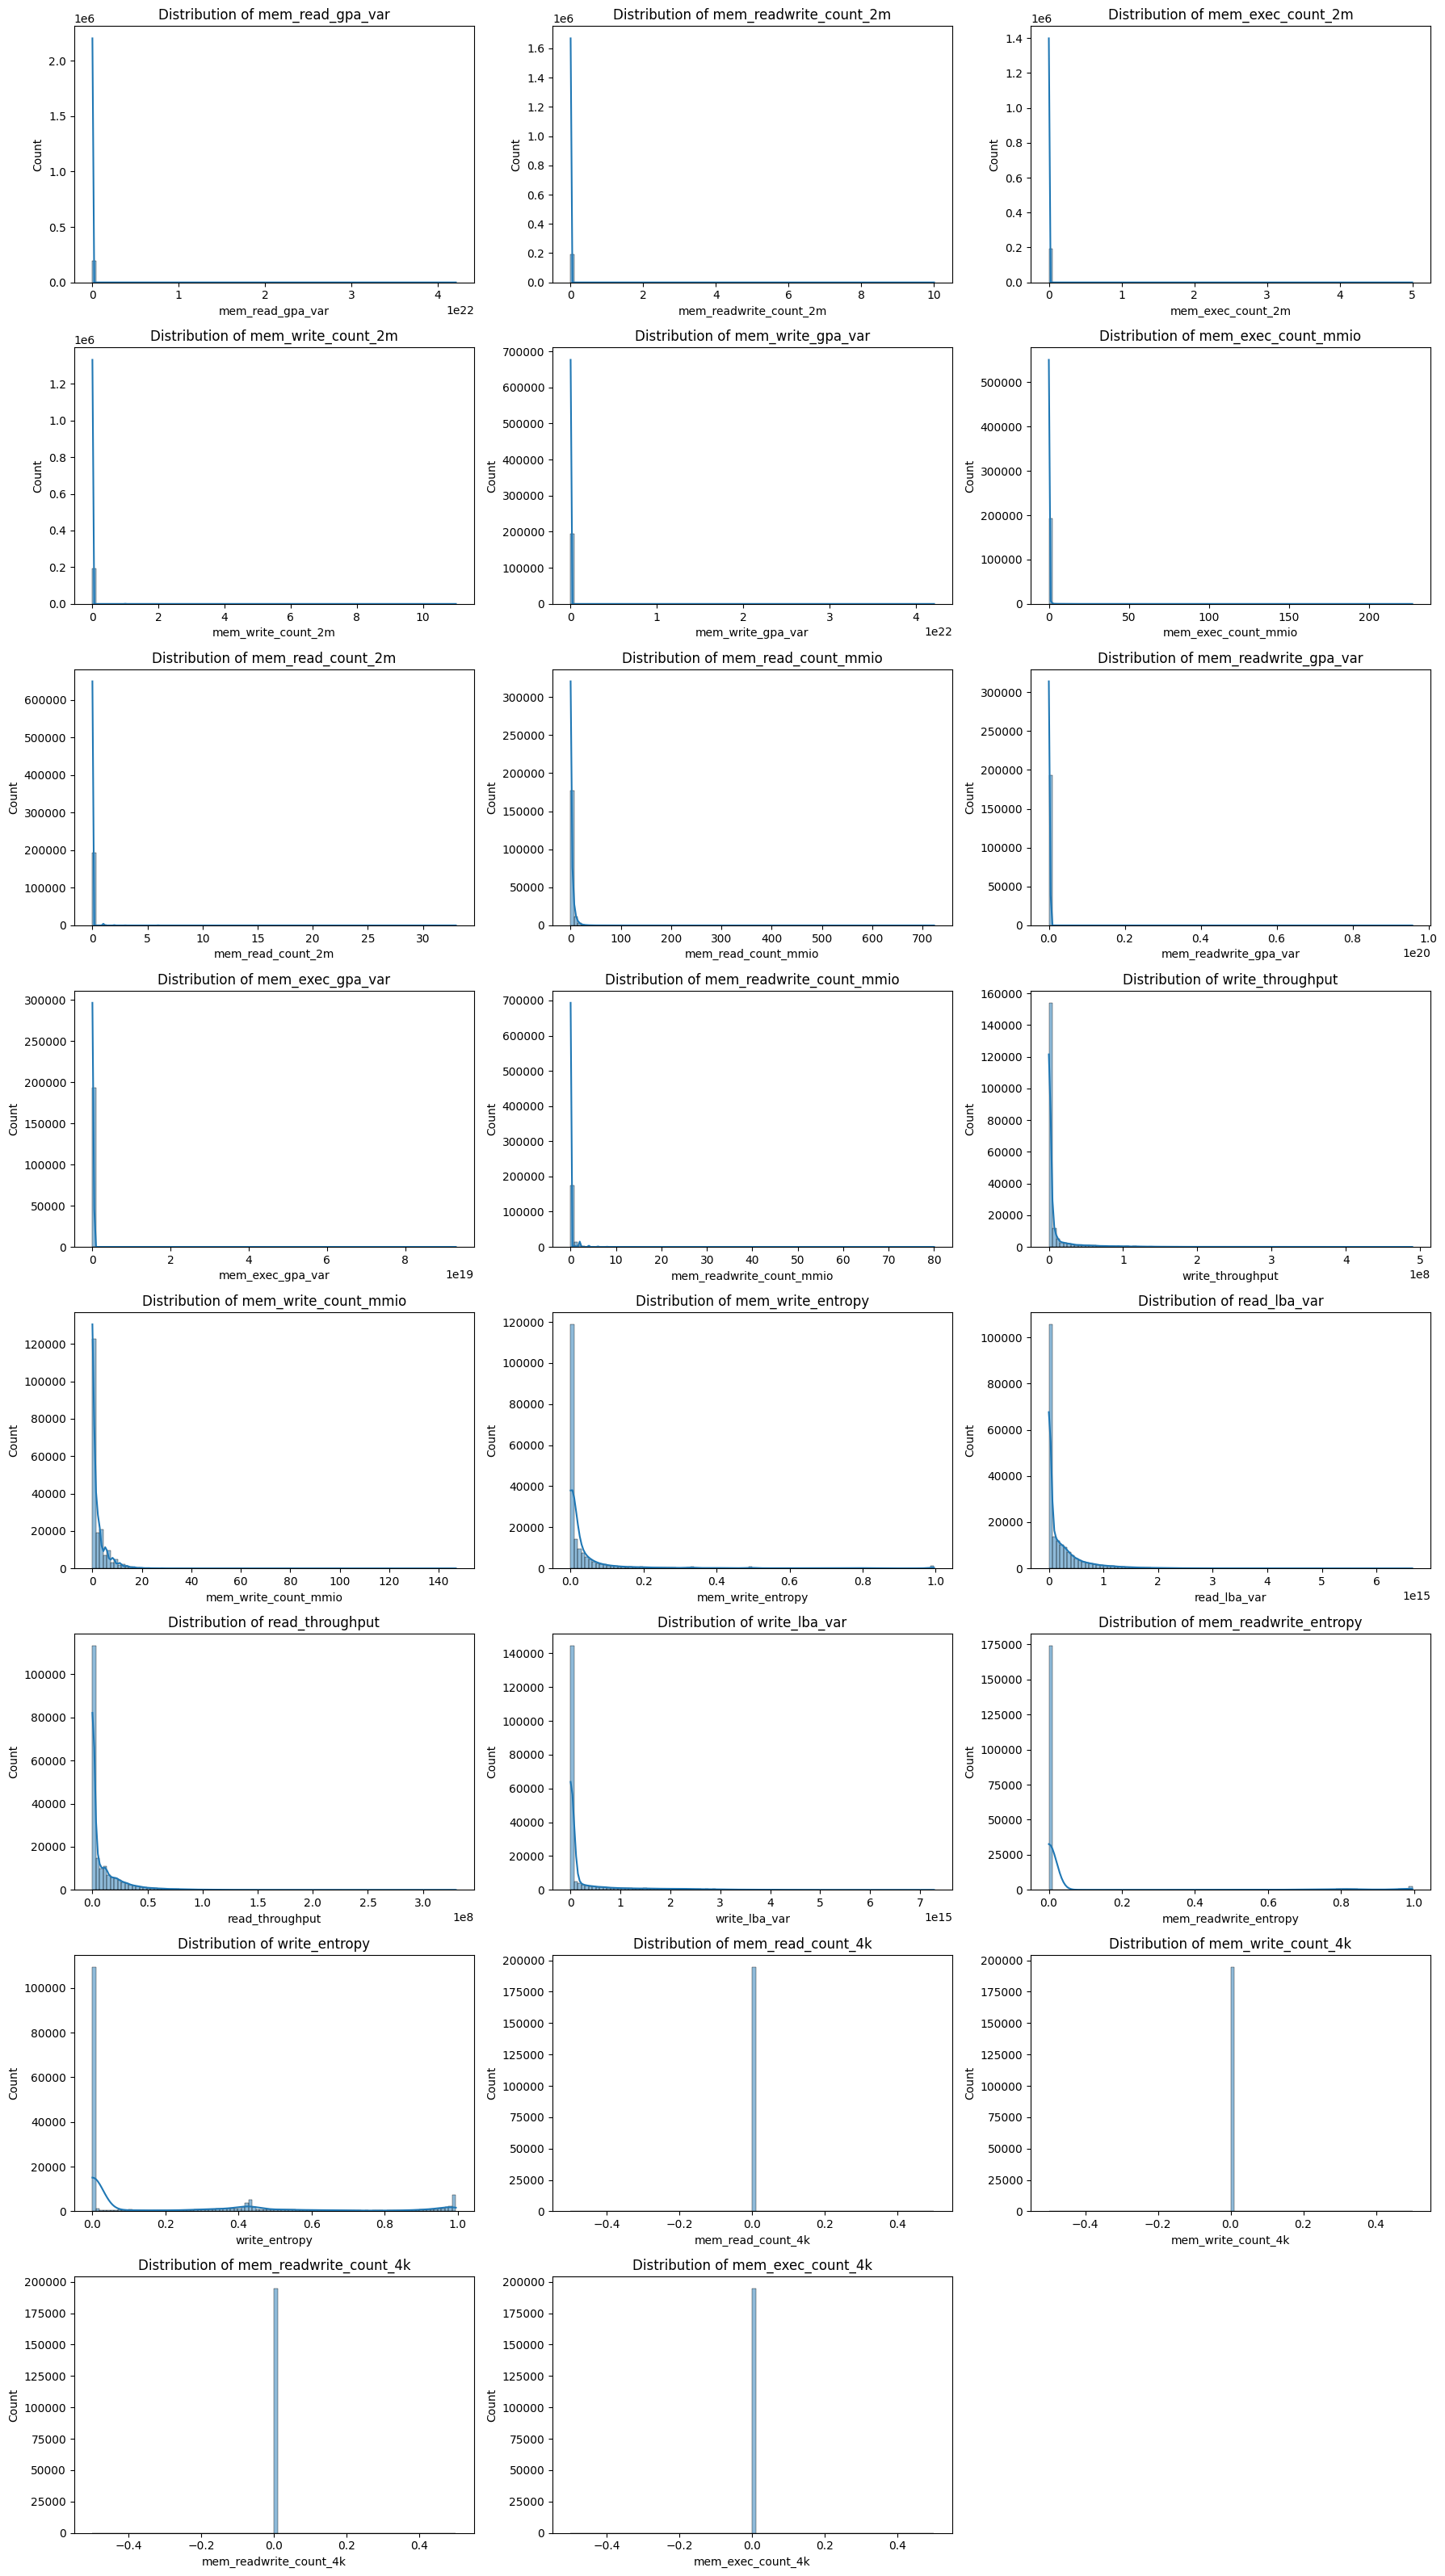

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

top_skewed = skewness.index.tolist()

n_cols = 3
n_rows = (len(top_skewed) + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, n_rows * 4))
axes = axes.flatten()

for idx, col in enumerate(top_skewed):
    sns.histplot(df[col], bins=100, kde=True, ax=axes[idx])
    axes[idx].set_title(f"Distribution of {col}")

for i in range(len(top_skewed), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()


In [10]:
numerical_cols = df.select_dtypes(include=[np.number]).columns.tolist()

numerical_cols.remove('label')
numerical_cols.remove('window_id')

df[numerical_cols] = df[numerical_cols].apply(np.log1p)

print("Log1p transformation applied to numerical features.")


Log1p transformation applied to numerical features.


In [11]:
skewness_after = df[numerical_cols].skew().sort_values(ascending=False)

display(skewness_after)


mem_readwrite_count_2m      49.524618
mem_exec_count_2m           45.451375
mem_write_count_2m          34.656417
mem_read_count_2m           14.771241
mem_exec_count_mmio         11.324433
mem_exec_gpa_var             9.628014
mem_readwrite_gpa_var        5.227107
mem_readwrite_count_mmio     3.727105
mem_write_entropy            3.555109
mem_readwrite_entropy        2.818673
mem_read_count_mmio          1.152065
write_entropy                0.902704
mem_write_count_mmio         0.761062
write_lba_var                0.601007
write_throughput             0.337940
mem_readwrite_count_4k       0.000000
mem_exec_count_4k            0.000000
mem_read_count_4k            0.000000
mem_write_count_4k           0.000000
mem_read_gpa_var            -0.296978
read_lba_var                -0.336067
mem_write_gpa_var           -0.555288
read_throughput             -0.686258
dtype: float64

In [13]:
variances = df[numerical_cols].var()

low_variance_cols = variances[variances < 1e-5]
print("Quasi-constant features (variance < 1e-5):")
display(low_variance_cols)


Quasi-constant features (variance < 1e-5):


mem_read_count_4k         0.0
mem_write_count_4k        0.0
mem_readwrite_count_4k    0.0
mem_exec_count_4k         0.0
dtype: float64

In [14]:
low_variance_features = ['mem_read_count_4k', 'mem_write_count_4k', 
                         'mem_readwrite_count_4k', 'mem_exec_count_4k']

family_variance = df.groupby('family')[low_variance_features].var()

display(family_variance)


mem_read_count_4k  mem_write_count_4k  mem_readwrite_count_4k  \
family                                                                    
AESCrypt                0.0                 0.0                     0.0   
Conti                   0.0                 0.0                     0.0   
Darkside                0.0                 0.0                     0.0   
Firefox                 0.0                 0.0                     0.0   
Idle                    0.0                 0.0                     0.0   
LockBit                 0.0                 0.0                     0.0   
Office                  0.0                 0.0                     0.0   
REvil                   0.0                 0.0                     0.0   
Ryuk                    0.0                 0.0                     0.0   
SDelete                 0.0                 0.0                     0.0   
WannaCry                0.0                 0.0                     0.0   
Zip                     0.0                 0.0                     0.0   

          mem_exec_count_4k  
family                       
AESCrypt                0.0  
Conti                   0.0  
Darkside                0.0  
Firefox                 0.0  
Idle                    0.0  
LockBit                 0.0  
Office                  0.0  
REvil                   0.0  
Ryuk                    0.0  
SDelete                 0.0  
WannaCry                0.0  
Zip                     0.0

In [15]:
to_drop = ['mem_read_count_4k', 'mem_write_count_4k', 
           'mem_readwrite_count_4k', 'mem_exec_count_4k']

df.drop(columns=to_drop, inplace=True)

print("Dropped constant features:", to_drop)
print("New shape:", df.shape)


Dropped constant features: ['mem_read_count_4k', 'mem_write_count_4k', 'mem_readwrite_count_4k', 'mem_exec_count_4k']
New shape: (194466, 22)


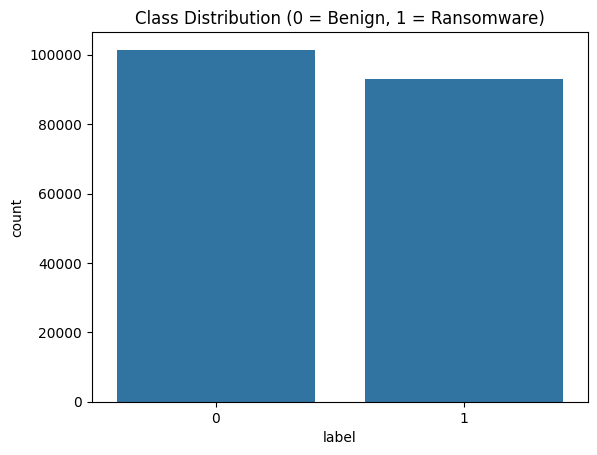

label
0    101443
1     93023
Name: count, dtype: int64


In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(x='label', data=df)
plt.title("Class Distribution (0 = Benign, 1 = Ransomware)")
plt.show()

print(df['label'].value_counts())


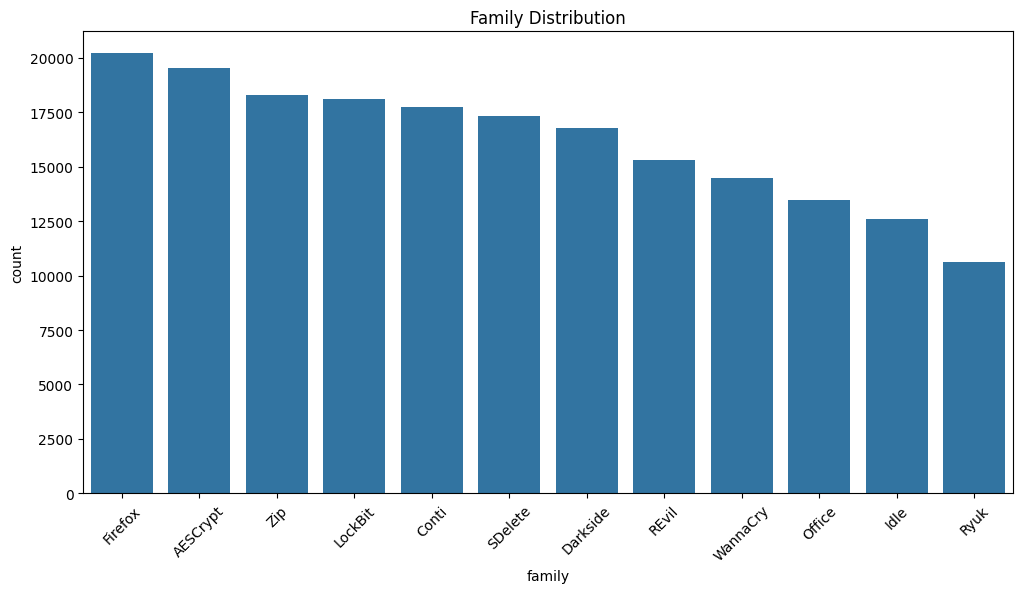

family
Firefox     20207
AESCrypt    19557
Zip         18295
LockBit     18093
Conti       17739
SDelete     17332
Darkside    16771
REvil       15296
WannaCry    14488
Office      13468
Idle        12584
Ryuk        10636
Name: count, dtype: int64


In [17]:
plt.figure(figsize=(12,6))
sns.countplot(x='family', data=df, order=df['family'].value_counts().index)
plt.title("Family Distribution")
plt.xticks(rotation=45)
plt.show()

print(df['family'].value_counts())

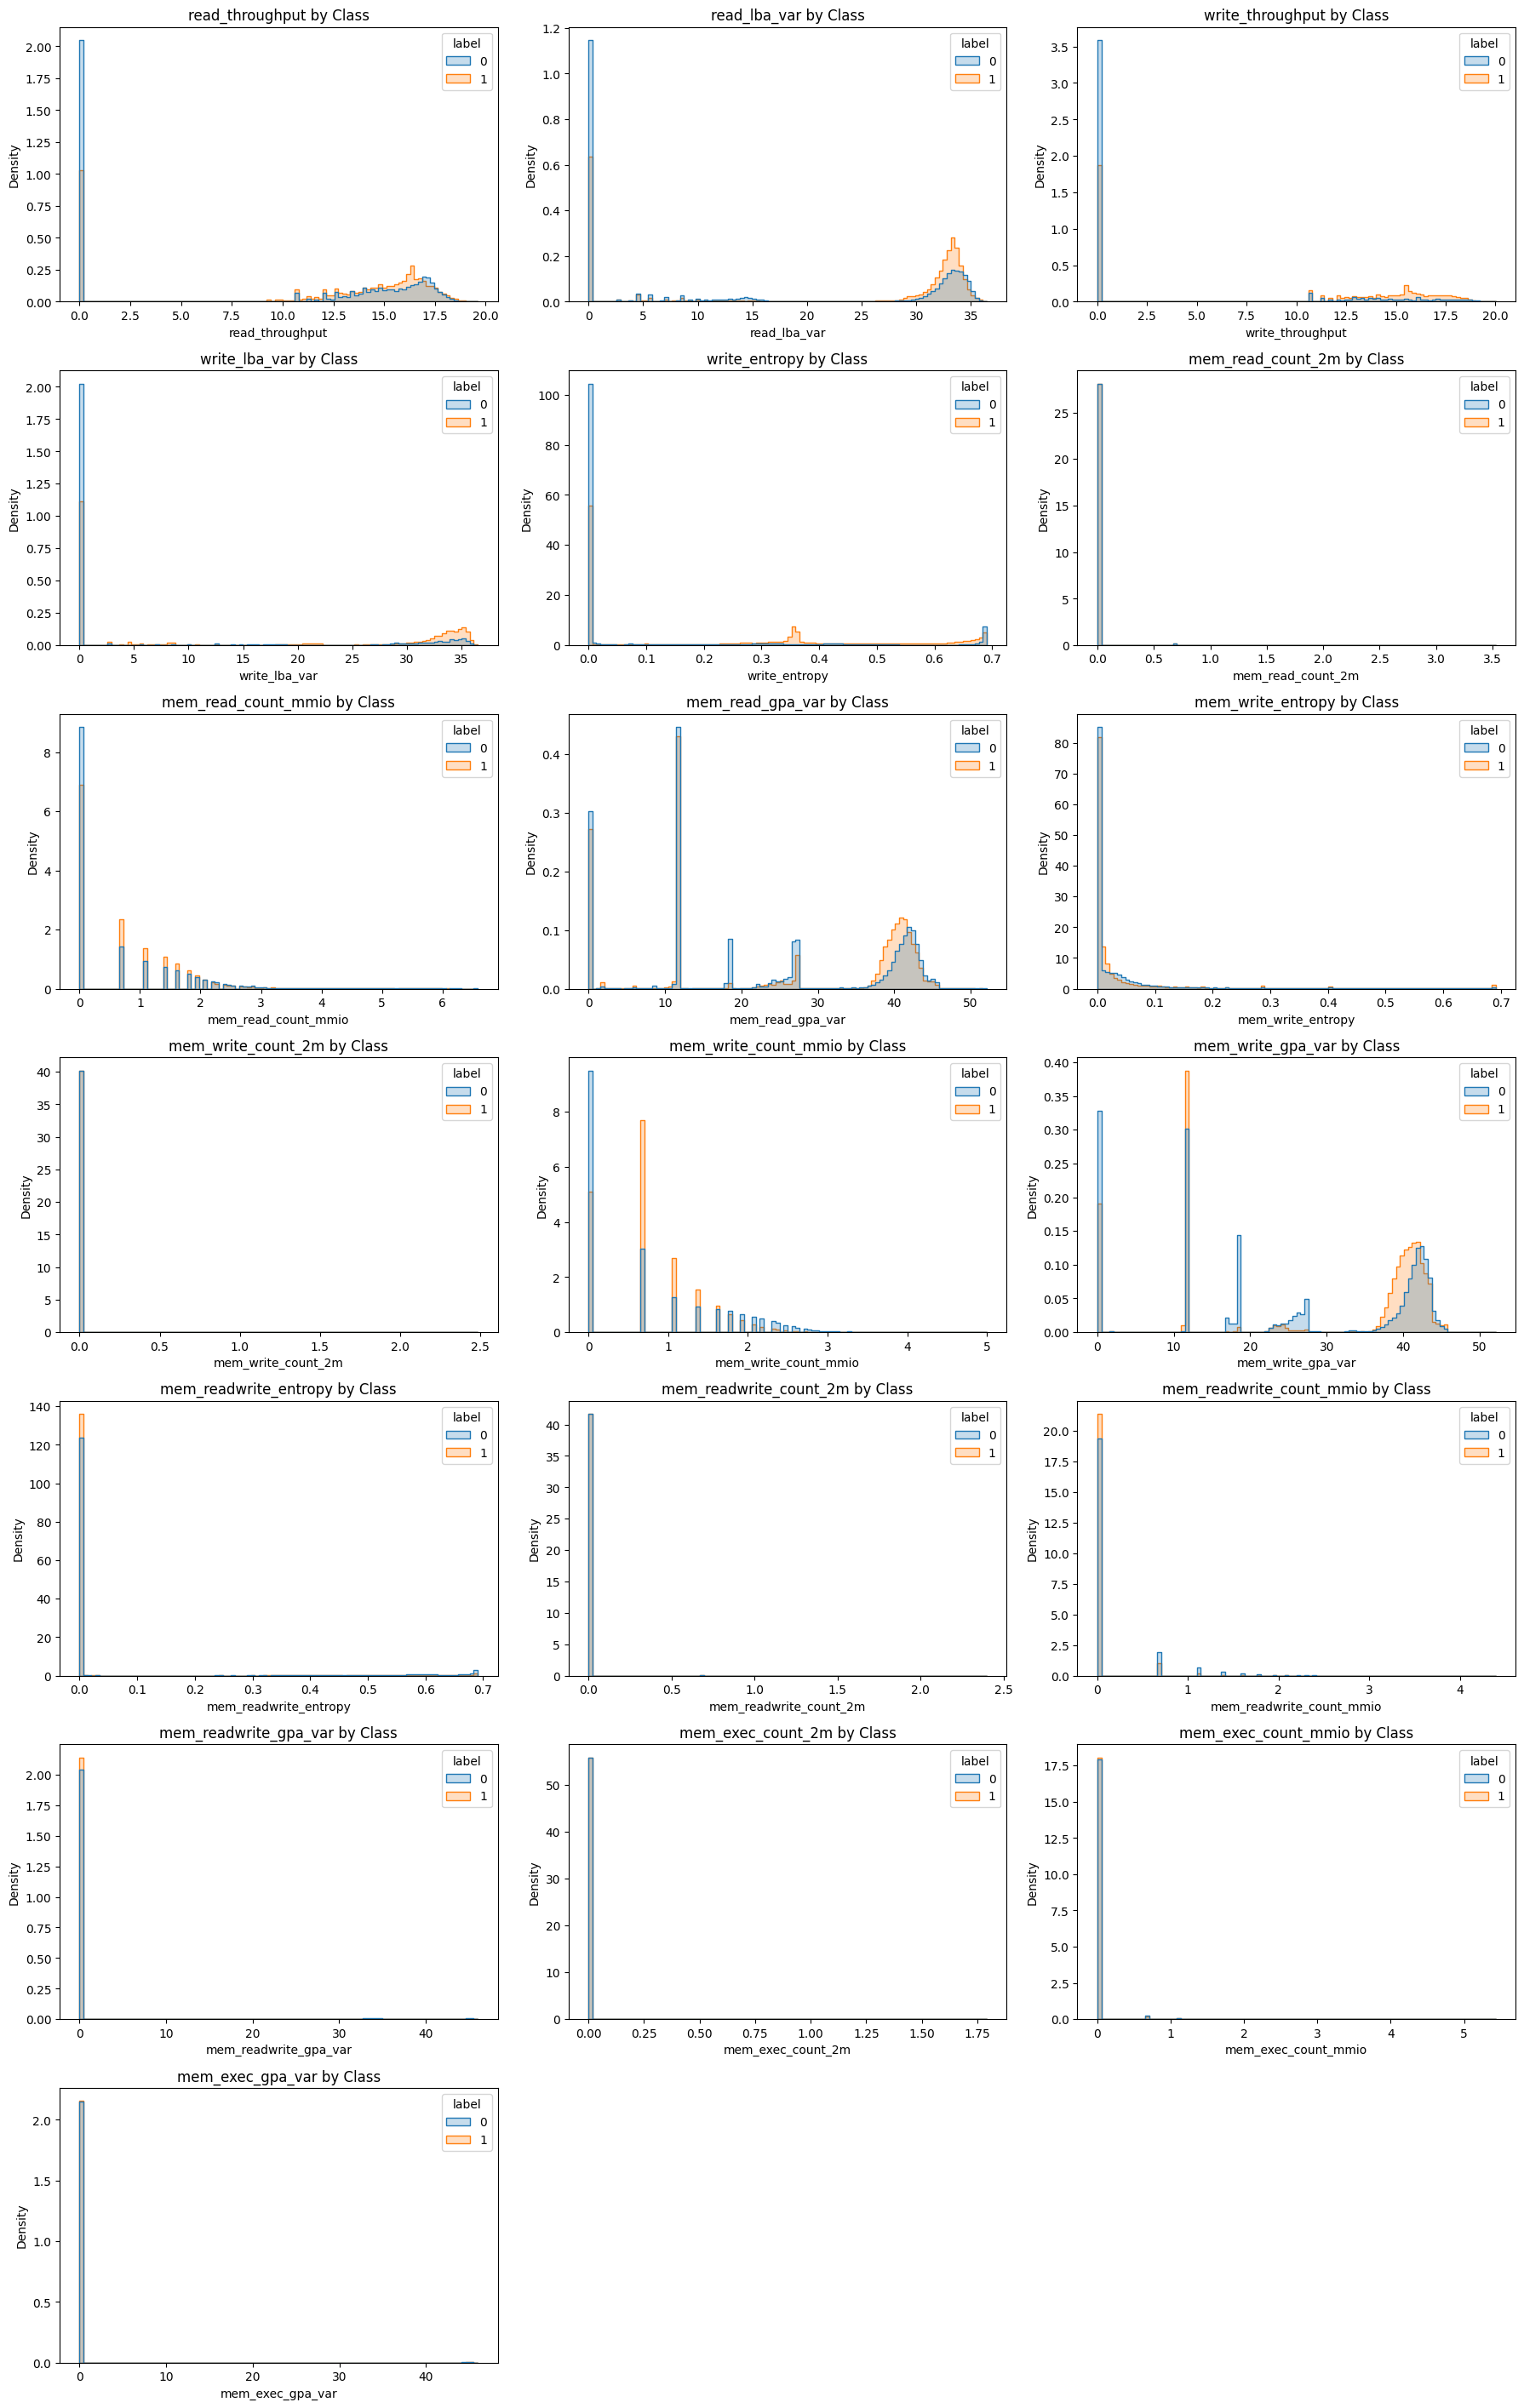

In [19]:
n_cols = 3
n_rows = (len(numerical_cols) + n_cols - 1) // n_cols
numerical_cols = [col for col in numerical_cols if col not in to_drop]

fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, n_rows * 4))
axes = axes.flatten()

for idx, col in enumerate(numerical_cols):
    sns.histplot(data=df, x=col, hue='label', bins=100, ax=axes[idx], element="step", stat="density", common_norm=False)
    axes[idx].set_title(f"{col} by Class")

for i in range(len(numerical_cols), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()


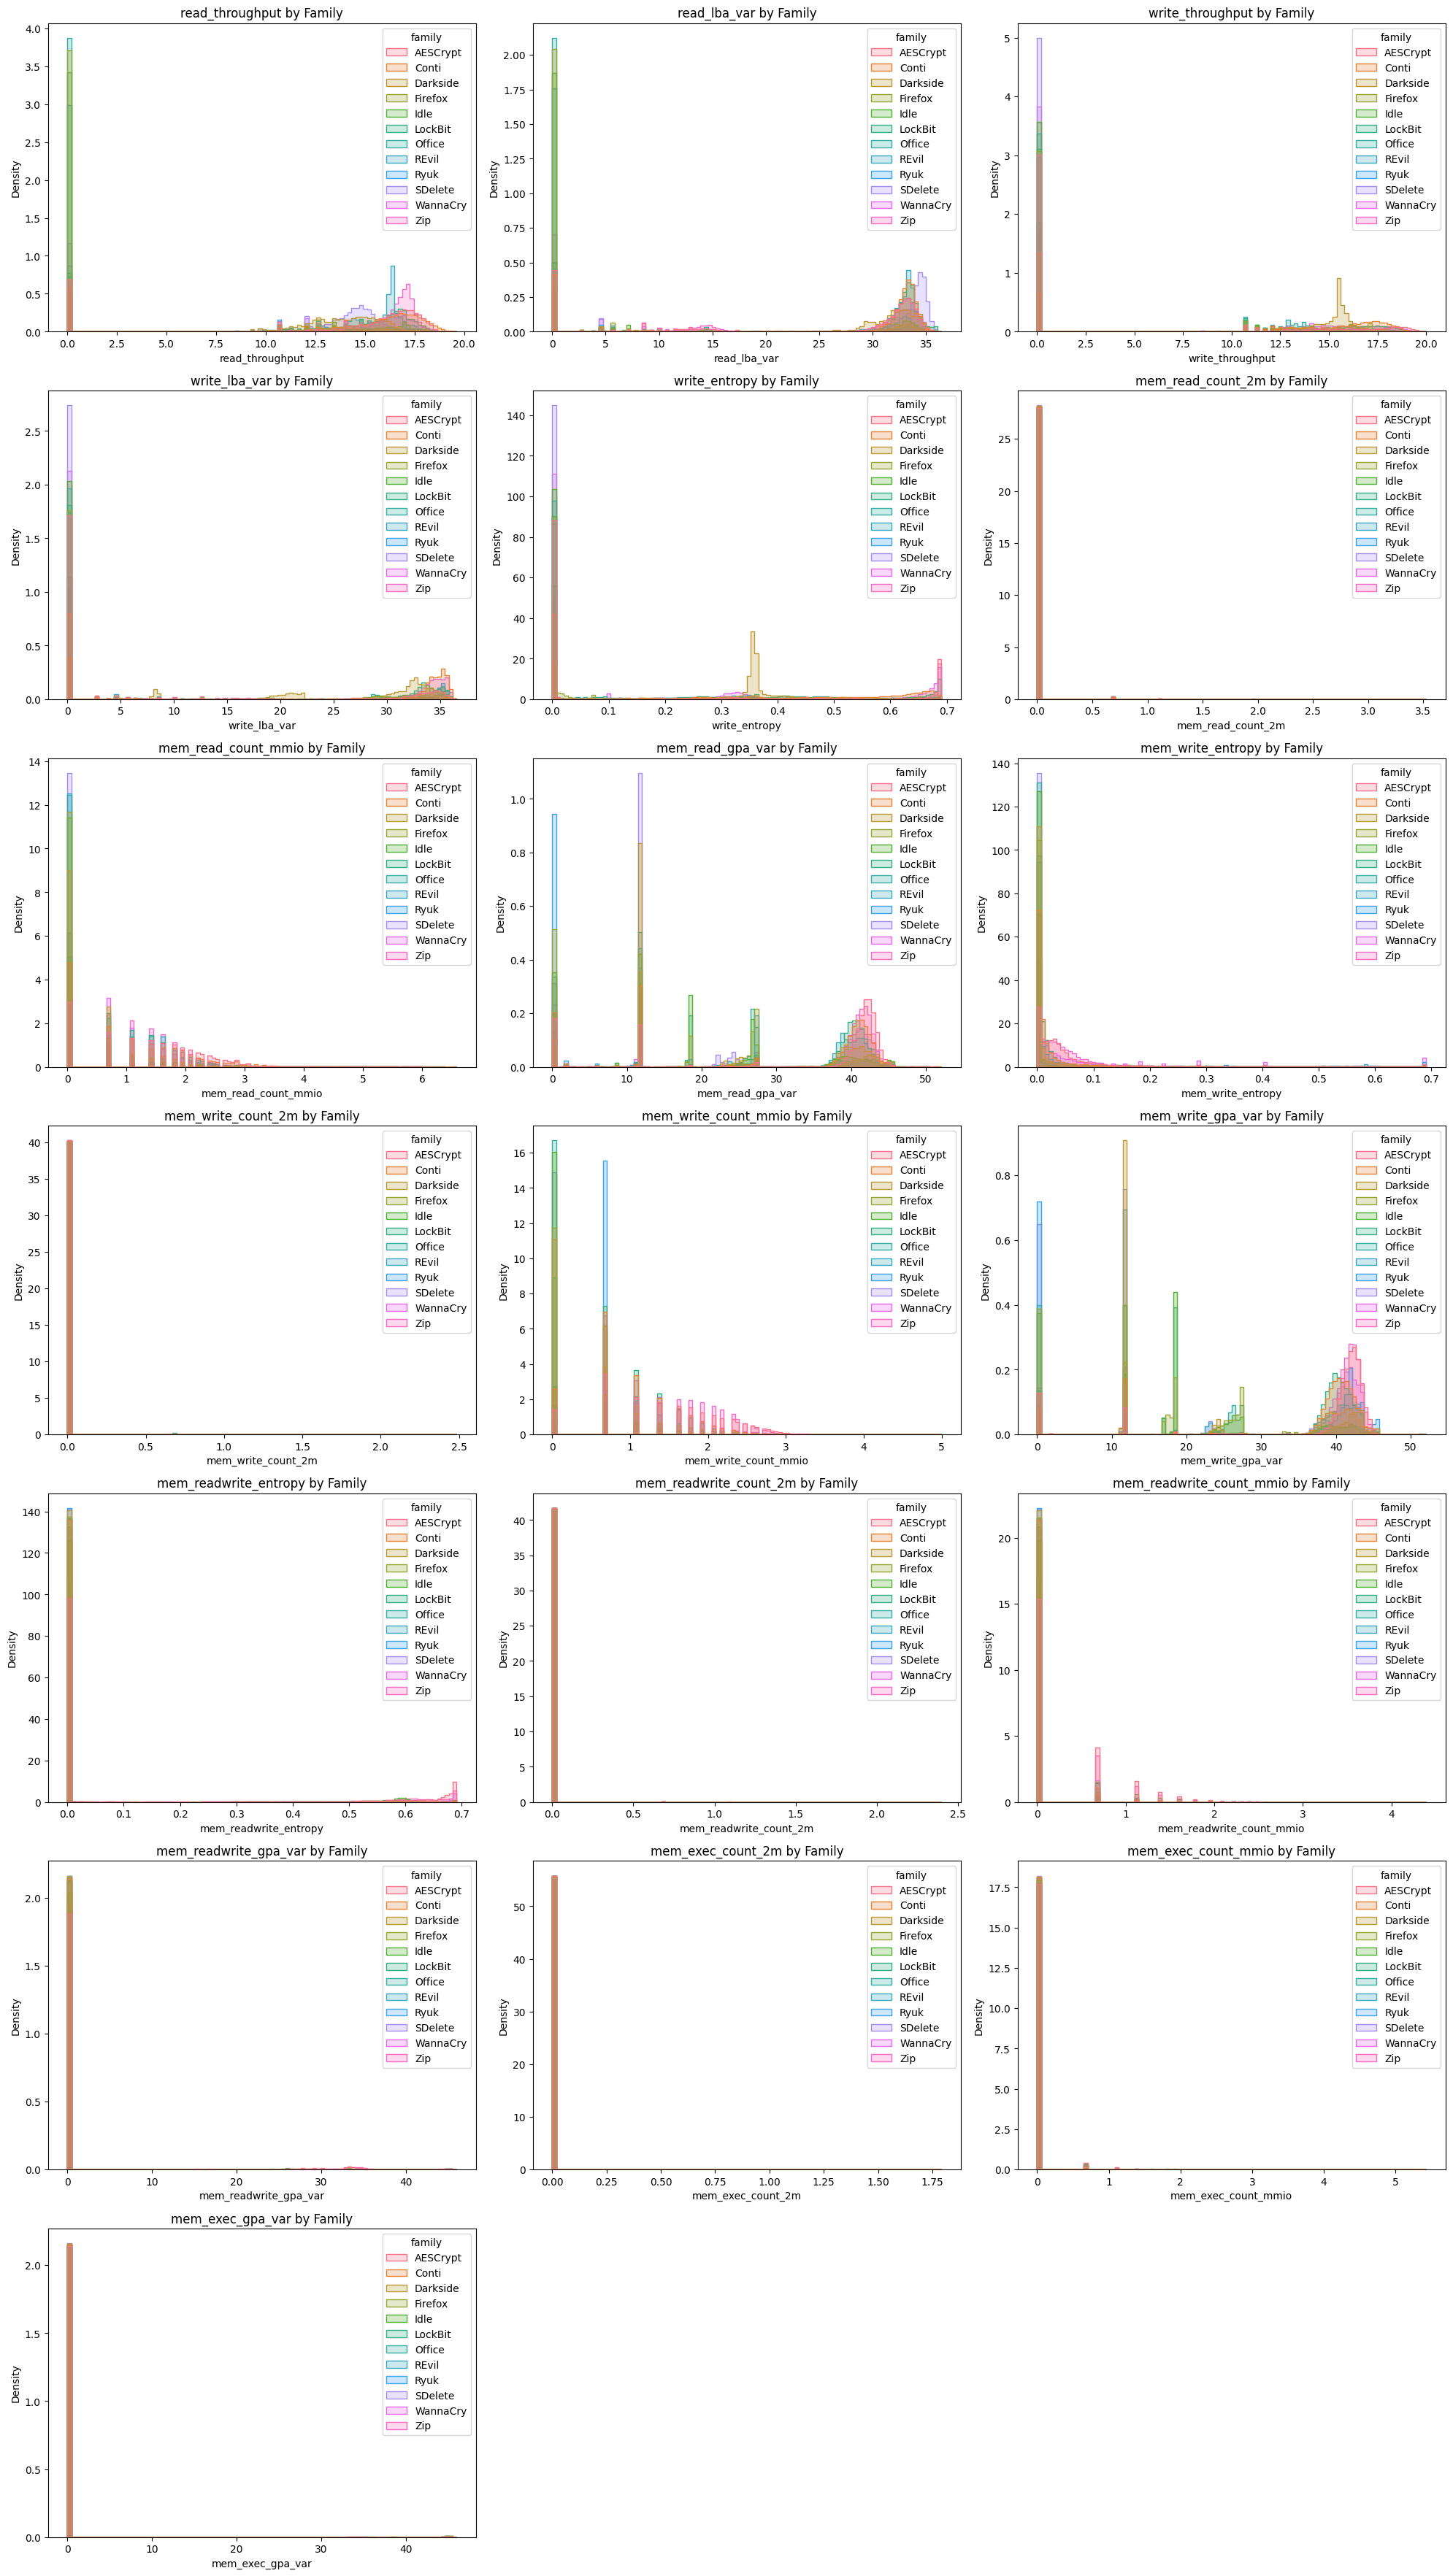

In [21]:
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, n_rows * 5))
axes = axes.flatten()

for idx, col in enumerate(numerical_cols):
    sns.histplot(data=df, x=col, hue='family', bins=100, ax=axes[idx], element="step", stat="density", common_norm=False)
    axes[idx].set_title(f"{col} by Family")

# Remove empty plots
for i in range(len(numerical_cols), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()


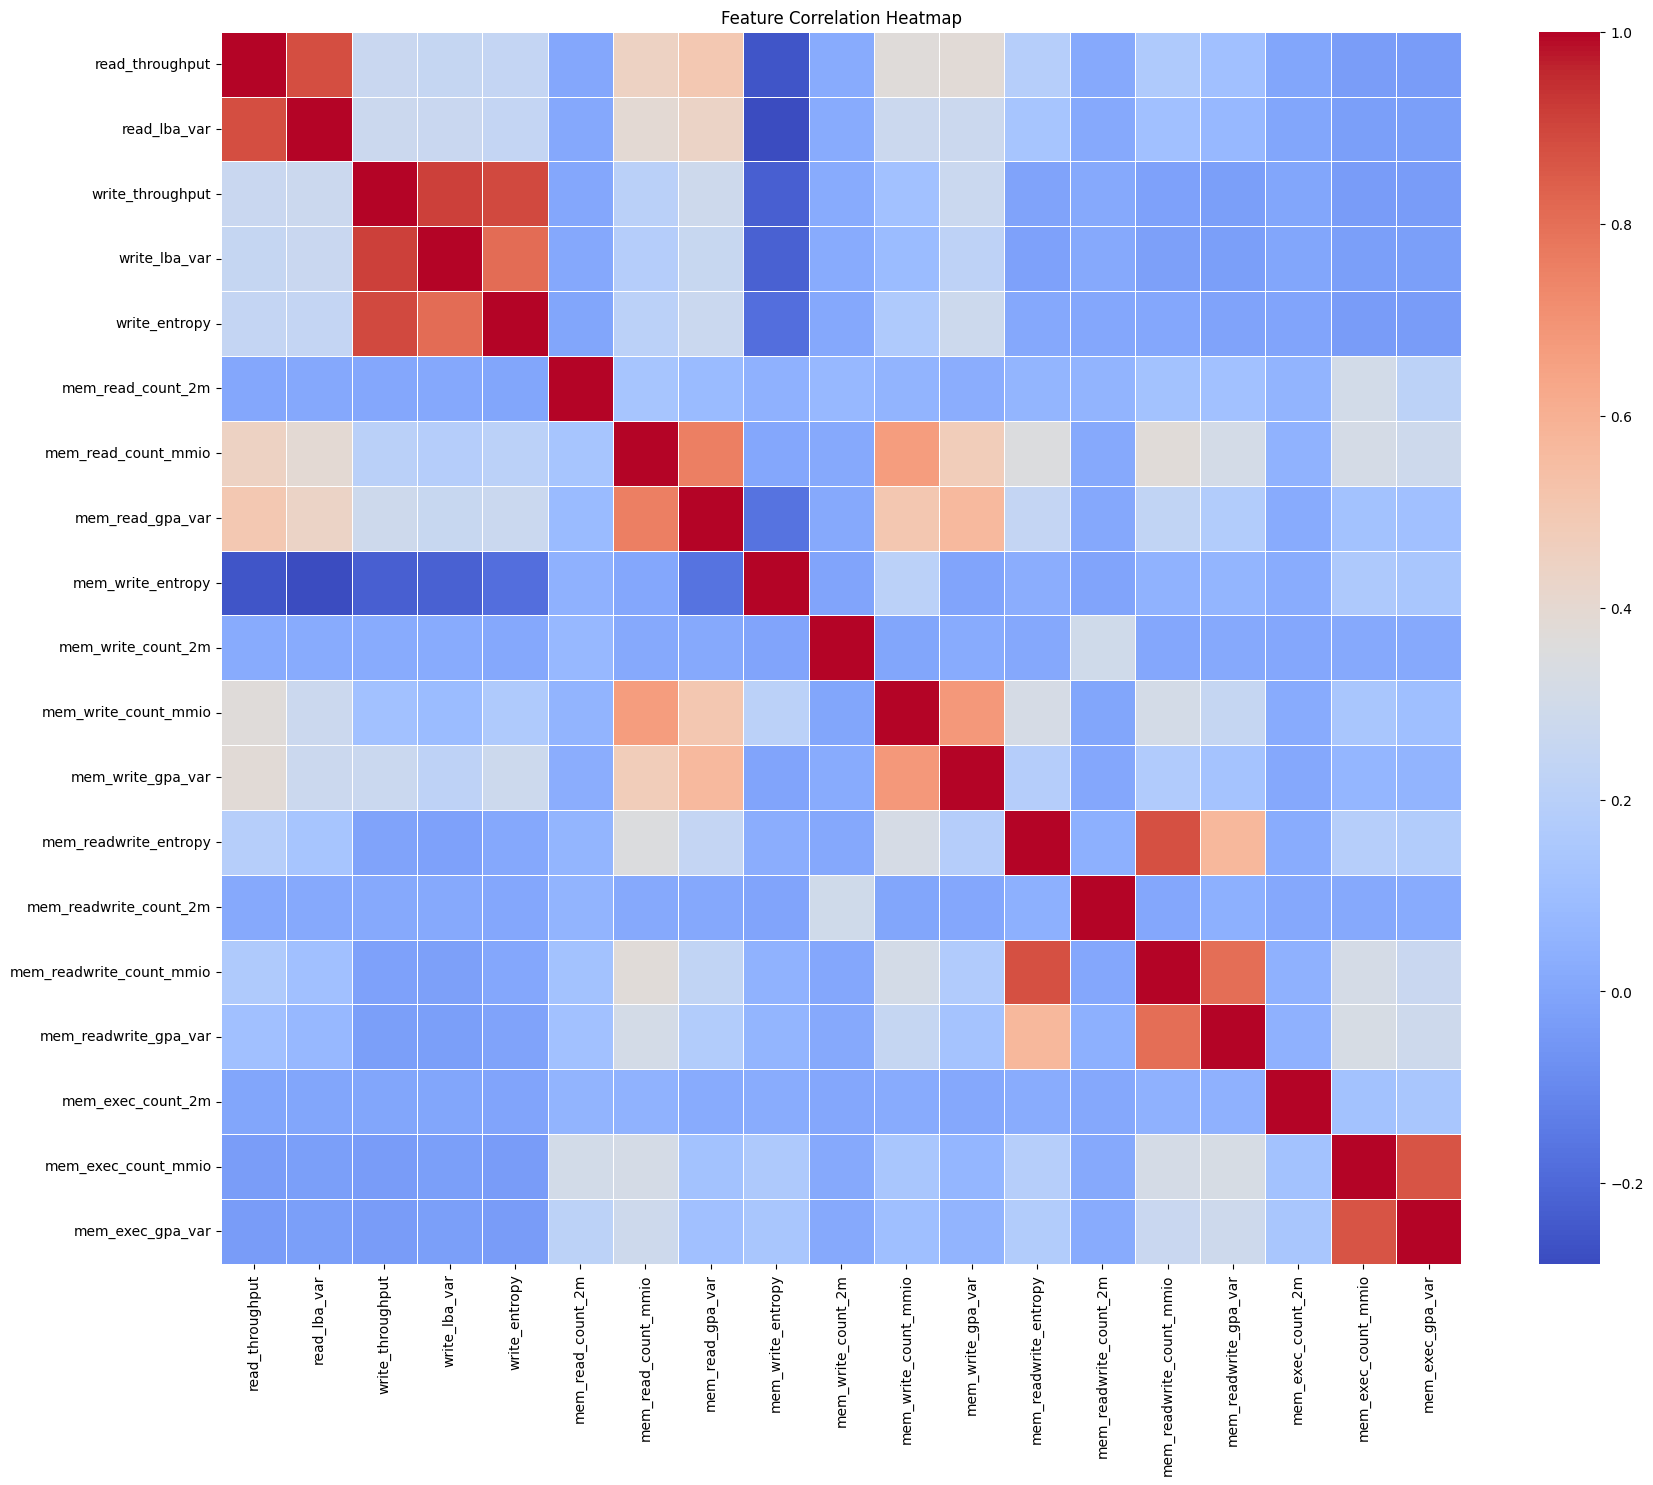

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt

corr = df[numerical_cols].corr()

plt.figure(figsize=(20, 16))
sns.heatmap(corr, cmap='coolwarm', annot=False, fmt=".2f", linewidths=0.5)
plt.title("Feature Correlation Heatmap")
plt.show()


In [26]:
corr_matrix = df[numerical_cols].corr()

upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

high_corr_pairs = upper.stack().reset_index()
high_corr_pairs.columns = ['Feature_1', 'Feature_2', 'Correlation']

high_corr_pairs = high_corr_pairs[high_corr_pairs['Correlation'].abs() >= 0.9]

high_corr_pairs = high_corr_pairs.sort_values(by='Correlation', ascending=False)

display(high_corr_pairs)


Feature_1      Feature_2  Correlation
35  write_throughput  write_lba_var     0.913596

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

df[numerical_cols] = scaler.fit_transform(df[numerical_cols])

print("Scaled numerical features using StandardScaler.")


In [27]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

df[numerical_cols] = scaler.fit_transform(df[numerical_cols])

print("Scaled numerical features using StandardScaler.")


Scaled numerical features using StandardScaler.


In [30]:
df.to_parquet("../Datasets/final_prepared_dataset.parquet")

print("Saved final prepared dataset.")

Saved final prepared dataset.
